
🚀 Iniciando entrenamiento...


CARGANDO DATOS
✅ SWIPE_LEFT: 100 muestras
✅ SWIPE_RIGHT: 100 muestras
✅ SWIPE_UP: 100 muestras
✅ SWIPE_DOWN: 100 muestras
✅ PINCH_OPEN: 100 muestras
✅ PINCH_CLOSE: 100 muestras
✅ FIST_CLOSE: 100 muestras
✅ OPEN_STATIC: 100 muestras

TOTAL: 800 muestras
Gestos: 8/8

Train: 640
Test: 160

Normalizando...

Entrenando Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Do


RESULTADOS
Train: 100.00%
Test: 96.88%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

  FIST_CLOSE       1.00      0.85      0.92        20
 OPEN_STATIC       1.00      1.00      1.00        20
 PINCH_CLOSE       0.95      0.95      0.95        20
  PINCH_OPEN       0.87      1.00      0.93        20
  SWIPE_DOWN       1.00      1.00      1.00        20
  SWIPE_LEFT       0.95      1.00      0.98        20
 SWIPE_RIGHT       1.00      1.00      1.00        20
    SWIPE_UP       1.00      0.95      0.97        20

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160


CONFUSION MATRIX
[[17  0  1  2  0  0  0  0]
 [ 0 20  0  0  0  0  0  0]
 [ 0  0 19  1  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  1  0 19]]

✅ Matriz guardada: ../models\confusion_matrix.png


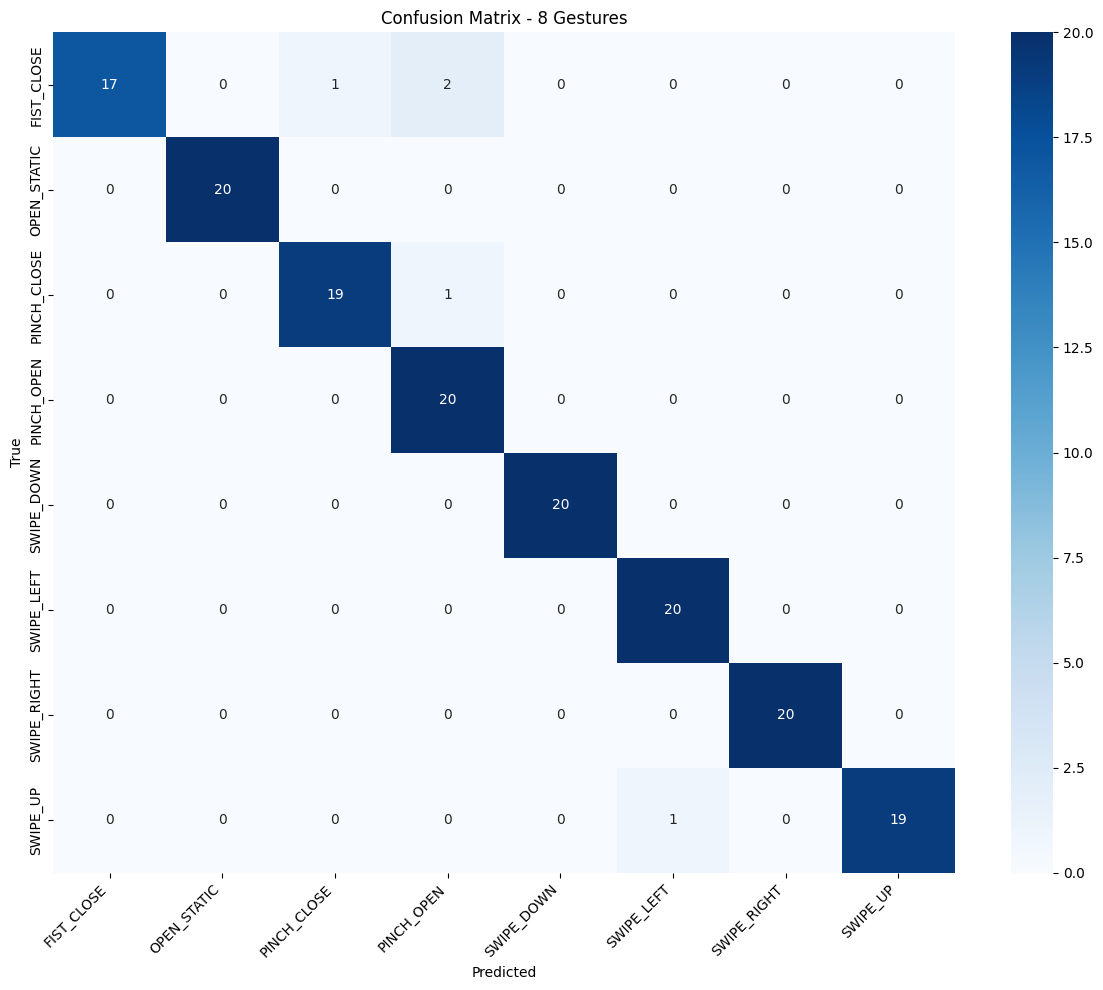

✅ Modelo: ../models\gesture_model_v3.pkl
✅ Scaler: ../models\feature_scaler_v3.pkl

COMPLETADO
Gestos: 8
  1. FIST_CLOSE
  2. OPEN_STATIC
  3. PINCH_CLOSE
  4. PINCH_OPEN
  5. SWIPE_DOWN
  6. SWIPE_LEFT
  7. SWIPE_RIGHT
  8. SWIPE_UP

Precisión: 96.88%

🎉 Listo para usar!
Siguiente: python main_app.py


In [1]:
"""
PASO 2: Entrenamiento del modelo
Random Forest con todos los gestos
"""

import pickle
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ========== CONFIGURACIÓN ==========
DATA_DIR = "../gesture_data"
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "gesture_model_v3.pkl")
SCALER_PATH = os.path.join(MODEL_DIR, "feature_scaler_v3.pkl")

ALL_GESTURES = [
    "SWIPE_LEFT",
    "SWIPE_RIGHT",
    "SWIPE_UP",
    "SWIPE_DOWN",
    "PINCH_OPEN",
    "PINCH_CLOSE",
    "FIST_CLOSE",
    "OPEN_STATIC"
]

def extract_motion_features(sequence):
    """Extraer features de movimiento"""
    if len(sequence) < 2:
        return None
    
    features = []
    
    # Normalizar por muñeca
    first_wrist = sequence[0][0]
    
    for frame_landmarks in sequence:
        normalized = frame_landmarks - first_wrist
        features.extend(normalized.flatten())
    
    # Velocidades
    velocities = []
    for i in range(1, len(sequence)):
        velocity = sequence[i] - sequence[i-1]
        velocities.extend(velocity.flatten())
    features.extend(velocities)
    
    # Aceleraciones
    accelerations = []
    for i in range(2, len(sequence)):
        accel = (sequence[i] - sequence[i-1]) - (sequence[i-1] - sequence[i-2])
        accelerations.extend(accel.flatten())
    features.extend(accelerations)
    
    # Trayectoria
    wrist_trajectory = np.array([frame[0] for frame in sequence])
    total_displacement = wrist_trajectory[-1] - wrist_trajectory[0]
    features.extend(total_displacement.flatten())
    
    # Desplazamiento
    x_disp = total_displacement[0]
    y_disp = total_displacement[1]
    features.extend([x_disp, y_disp, np.sqrt(x_disp**2 + y_disp**2)])
    
    # Velocidad media
    mean_velocity = np.mean([
        np.linalg.norm(wrist_trajectory[i] - wrist_trajectory[i-1])
        for i in range(1, len(wrist_trajectory))
    ])
    features.append(mean_velocity)
    
    return np.array(features)

def load_data():
    """Cargar todos los datos"""
    X = []
    y = []
    
    print("\n" + "="*70)
    print("CARGANDO DATOS")
    print("="*70)
    
    gesture_counts = {}
    
    for gesture in ALL_GESTURES:
        file_path = os.path.join(DATA_DIR, f"{gesture}.pkl")
        
        if not os.path.exists(file_path):
            print(f"⚠️  {gesture}: NO ENCONTRADO")
            continue
        
        with open(file_path, 'rb') as f:
            sequences = pickle.load(f)
        
        valid = 0
        for sequence in sequences:
            features = extract_motion_features(sequence)
            if features is not None:
                X.append(features)
                y.append(gesture)
                valid += 1
        
        gesture_counts[gesture] = valid
        print(f"✅ {gesture}: {valid} muestras")
    
    print(f"\n{'='*70}")
    print(f"TOTAL: {len(X)} muestras")
    print(f"Gestos: {len(gesture_counts)}/{len(ALL_GESTURES)}")
    print("="*70)
    
    return np.array(X), np.array(y), gesture_counts

def train():
    """Entrenar modelo"""
    print("\n🚀 Iniciando entrenamiento...\n")
    
    X, y, counts = load_data()
    
    if len(X) == 0:
        print("❌ No hay datos")
        return
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTrain: {len(X_train)}")
    print(f"Test: {len(X_test)}")
    
    # Normalizar
    print("\nNormalizando...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Entrenar
    print("\nEntrenando Random Forest...")
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Evaluar
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    
    print(f"\n{'='*70}")
    print("RESULTADOS")
    print(f"{'='*70}")
    print(f"Train: {train_acc*100:.2f}%")
    print(f"Test: {test_acc*100:.2f}%")
    
    # Reporte
    y_pred = model.predict(X_test_scaled)
    print(f"\n{'='*70}")
    print("CLASSIFICATION REPORT")
    print(f"{'='*70}")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    print(f"\n{'='*70}")
    print("CONFUSION MATRIX")
    print(f"{'='*70}")
    print(cm)
    
    # Visualizar
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {len(model.classes_)} Gestures')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    confusion_path = os.path.join(MODEL_DIR, 'confusion_matrix.png')
    plt.savefig(confusion_path, dpi=150, bbox_inches='tight')
    print(f"\n✅ Matriz guardada: {confusion_path}")
    plt.show()
    
    # Guardar modelo
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Modelo: {MODEL_PATH}")
    
    with open(SCALER_PATH, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"✅ Scaler: {SCALER_PATH}")
    
    print(f"\n{'='*70}")
    print("COMPLETADO")
    print(f"{'='*70}")
    print(f"Gestos: {len(model.classes_)}")
    for i, g in enumerate(model.classes_, 1):
        print(f"  {i}. {g}")
    print(f"\nPrecisión: {test_acc*100:.2f}%")
    print(f"{'='*70}")
    
    return model, scaler

if __name__ == "__main__":
    model, scaler = train()
    print("\n🎉 Listo para usar!")
    print("Siguiente: python main_app.py")